In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split

import pennylane as qml
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sklearn.decomposition 

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

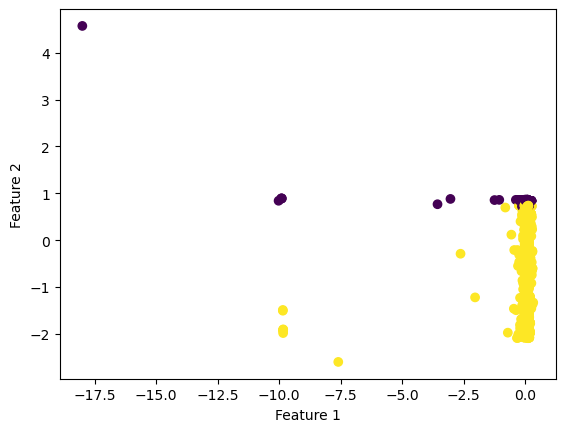

In [2]:
# Exercise 1

data = pd.read_csv('ddos_ldap.csv')


# Select all features except for the first and last one
features = list(data.columns)[1:-1]

n_features = 2
x = StandardScaler().fit_transform(np.array(data.drop(columns=['Label'])))
y = np.array(data['Label'].astype('category').cat.codes.astype(int))

np.random.seed(1967)

shuffled = np.random.permutation(len(x))
x = x[shuffled]
y = np.array(y)[shuffled]

ICA = sklearn.decomposition.FastICA(n_components=n_features)
ICA.fit(x)
x = ICA.transform(x)

# plot the first two components
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

minmax_scale = MinMaxScaler((-1, 1)).fit(x)
x = minmax_scale.transform(x)


trainX, testX, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)

trainy = tf.one_hot(trainy, depth=2)
testy = tf.one_hot(testy, depth=2)

In [3]:
# Define the number of qubits, layers, and data dimension for the quantum model
n_qubits = 2
layers = 2
data_dimension = 2

# Set up the quantum device using the default.qubit simulator
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum node (qnode) using the AngleEmbedding and StronglyEntanglingLayers templates
# The qnode takes inputs and weights as arguments and returns the expectation values of Pauli-Z operators
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the shape of the weights for the quantum model
weight_shapes = {"weights": (layers,n_qubits,3)}

# Create a sequential Keras model
model = tf.keras.models.Sequential()

# Add a Dense layer with ReLU activation for classical data processing
model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim=2))

# Add the quantum neural network (QNN) layer using the defined qnode and weight shapes
# This layer integrates the quantum circuit with classical data processing
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))

# Add another Dense layer with softmax activation for final classification
model.add(tf.keras.layers.Dense(data_dimension, activation='softmax'))

# Set up the Adam optimizer with a learning rate of 0.01
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


In [4]:
%%time

history = model.fit(trainX, trainy, validation_data=(trainX, trainy), epochs=50, batch_size=5)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6152 - loss: 0.6142 - val_accuracy: 0.9737 - val_loss: 0.3749
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8920 - loss: 0.3450 - val_accuracy: 0.8843 - val_loss: 0.2712
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9043 - loss: 0.2596 - val_accuracy: 0.8805 - val_loss: 0.2356
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8968 - loss: 0.2415 - val_accuracy: 0.8824 - val_loss: 0.2050
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9221 - loss: 0.1918 - val_accuracy: 0.9501 - val_loss: 0.1758
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9280 - loss: 0.1769 - val_accuracy: 0.8815 - val_loss: 0.2071
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9232 - loss: 0.1738 - val_accuracy: 0.9737 - val_loss: 0.1570
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9429 - loss: 0.1528 - val_accuracy: 0.

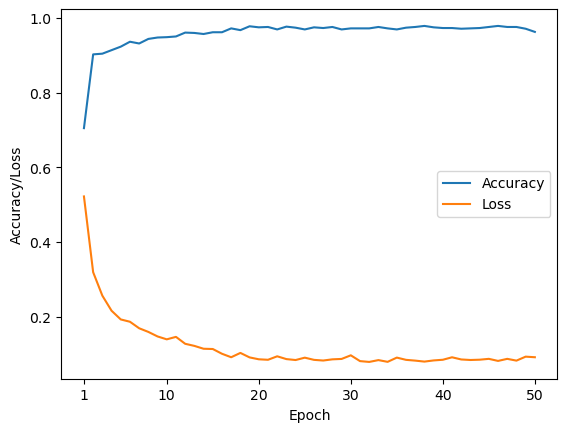

In [5]:
# Plot the training accuracy and loss
fig, ax = plt.subplots()
ax.plot(np.arange(1, 51), history.history['accuracy'], label='Accuracy')
ax.plot(np.arange(1, 51), history.history['loss'], label='Loss')
ax.set_ylabel('Accuracy/Loss')
ax.set_xlabel('Epoch')
ax.set_xticks([1] + list(range(10, 51, 10)))
ax.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9692 - loss: 0.1050
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted labels:
 [1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1
 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1
 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0
 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 

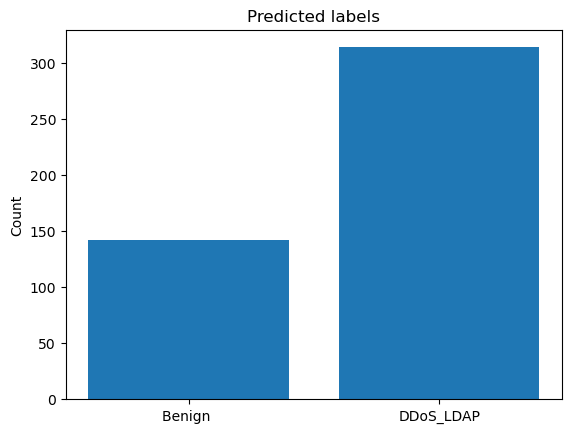

In [6]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testX, testy)

# Print the predicted labels
y_pred = model.predict(testX)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Predicted labels:\n", y_pred_labels)

# Create a bar graph to show the predicted labels
labels, counts = np.unique(y_pred_labels, return_counts=True)
plt.bar(labels, counts)
plt.xticks(labels, ['Benign ', 'DDoS_LDAP'])
plt.ylabel('Count')
plt.title('Predicted labels')
plt.show()

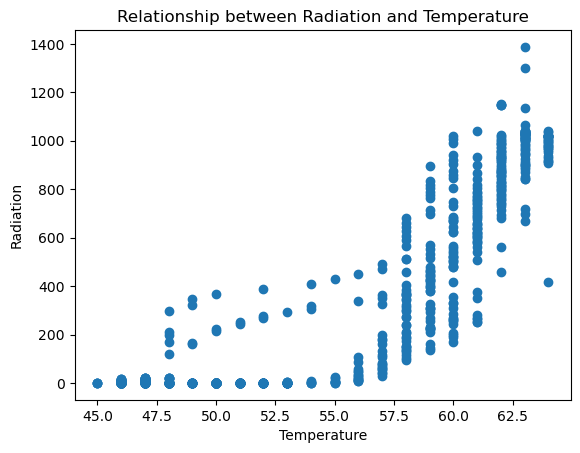

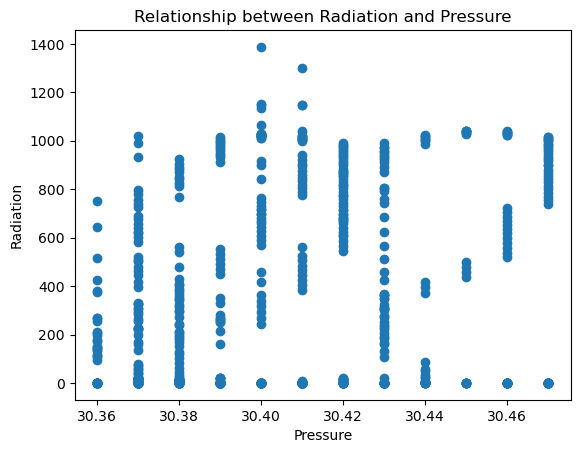

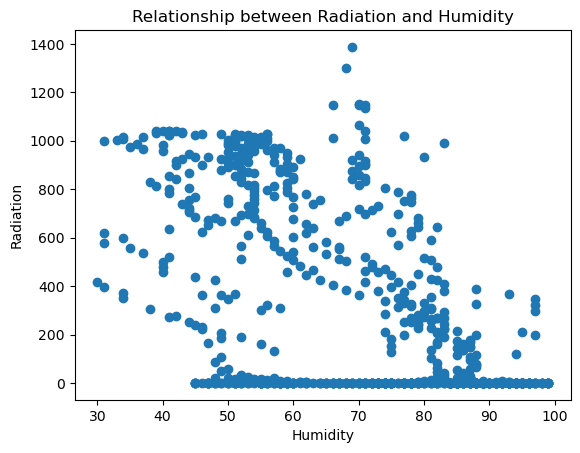

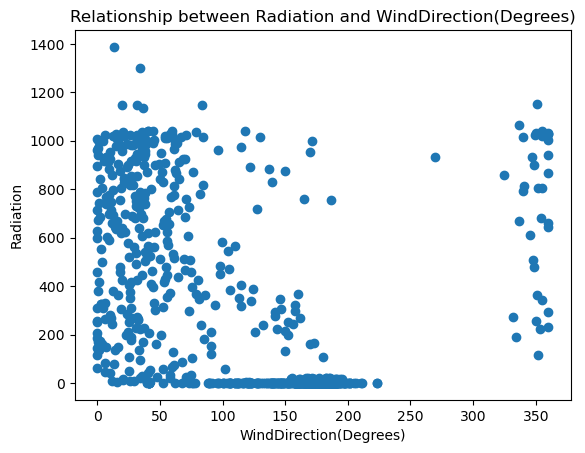

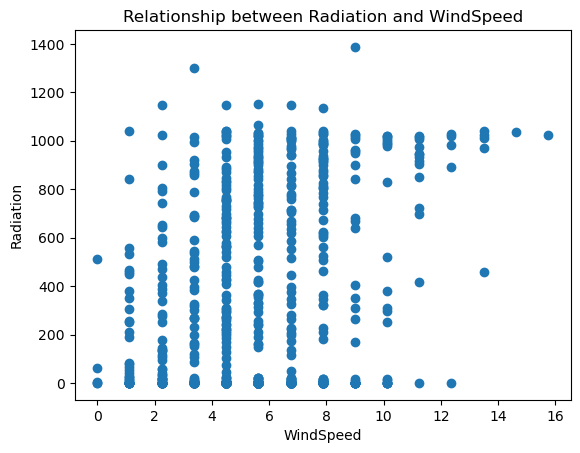

In [23]:
# Exercise 2

data = pd.read_csv('solar_radiation.csv')


# Select all features except for the first and last one
features = list(data.columns)[1:-1]

# Create scatter plots for each feature
for feature in features:
    plt.scatter(data[feature], data['Radiation'])
    plt.xlabel(feature)
    plt.ylabel('Radiation')
    plt.title('Relationship between Radiation and ' + feature)
    plt.show()

n_features = 6
x = StandardScaler().fit_transform(np.array(data.drop(columns=['Label'])))
y = np.array(data['Label'].astype('category').cat.codes.astype(int))

np.random.seed(1967)
shuffled = np.random.permutation(len(x))
x = x[shuffled]
y = np.array(y)[shuffled]

ICA = sklearn.decomposition.FastICA(n_components=n_features)
ICA.fit(x)
x = ICA.transform(x)

minmax_scale = MinMaxScaler((-1, 1)).fit(x)
x = minmax_scale.transform(x)


trainX, testX, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)

trainy = tf.one_hot(trainy, depth=6)
testy = tf.one_hot(testy, depth=6)

In [24]:
# Define the number of qubits, layers, and data dimension for the quantum model
n_qubits = 6
layers = 2
data_dimension = 6

# Set up the quantum device using the default.qubit simulator
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum node (qnode) using the AngleEmbedding and StronglyEntanglingLayers templates
# The qnode takes inputs and weights as arguments and returns the expectation values of Pauli-Z operators
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the shape of the weights for the quantum model
weight_shapes = {"weights": (layers,n_qubits,3)}

# Create a sequential Keras model
model = tf.keras.models.Sequential()

# Add a Dense layer with ReLU activation for classical data processing
model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim=6))

# Add the quantum neural network (QNN) layer using the defined qnode and weight shapes
# This layer integrates the quantum circuit with classical data processing
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))

# Add another Dense layer with softmax activation for final classification
model.add(tf.keras.layers.Dense(data_dimension, activation='softmax'))

# Set up the Adam optimizer with a learning rate of 0.01
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


In [25]:
%%time

history = model.fit(trainX, trainy, validation_data=(trainX, trainy), epochs=20, batch_size=5)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4856 - loss: 1.2397 - val_accuracy: 0.9422 - val_loss: 0.3200
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9621 - loss: 0.2430 - val_accuracy: 0.9352 - val_loss: 0.2073
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9303 - loss: 0.2199 - val_accuracy: 0.9492 - val_loss: 0.1694
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9579 - loss: 0.1587 - val_accuracy: 0.9562 - val_loss: 0.1518
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9592 - loss: 0.1482 - val_accuracy: 0.9597 - val_loss: 0.1449
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9653 - loss: 0.1340 - val_accuracy: 0.9580 - val_loss: 0.1476
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9535 - loss: 0.1478 - val_accuracy: 0.9597 - val_loss: 0.1387
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9667 - loss: 0.1258 - val_accuracy: 0.